修正字型無法顯示問題

起始時間: 2000-01-04 00:00:00 
結束時間 2024-04-03 00:00:00
年化報酬: 0.139
年化標準差: 0.309
年化夏普: 0.417
MDD: 0.68


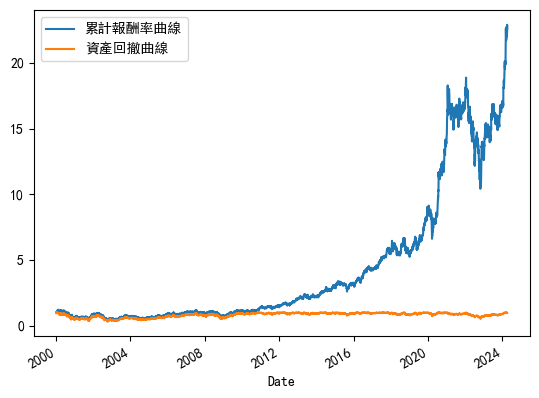

起始時間: 1980-12-12 00:00:00 
結束時間 2024-04-04 00:00:00
年化報酬: 0.187
年化標準差: 0.444
年化夏普: 0.4
MDD: 0.818


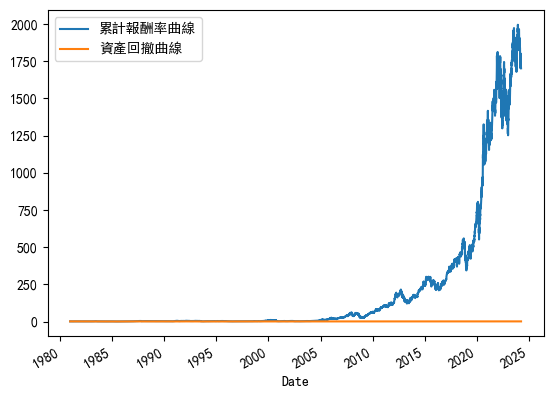

In [1]:

"""
單筆定額計算實務
"""
# matplotlib
import matplotlib.pyplot as plt
# 載入函數工具檔
import pandas as pd
# 以下為自訂函數「getDataYF」「getDataFM」使用
import os
import yfinance as yf

# 配置 matplotlib 的字體為支援中文的字體
plt.rcParams["font.sans-serif"] = ["SimHei"]  # 例如使用微軟雅黑
plt.rcParams["axes.unicode_minus"] = False  # 正確顯示負號


def getDataYF(prod):
    # 備份文件的資料夾
    folder_name = "data"
    # 檢查資料夾是否存在
    if not os.path.exists(folder_name):
        os.makedirs(folder_name)

    # 1. 定義備份檔案名稱
    bakfile = os.path.join(folder_name, f"yf_{prod}.csv")
    # 2. 檢視是否有歷史資料(本地端)
    if os.path.exists(bakfile):
        yfdata = pd.read_csv(bakfile)
        yfdata["Date"] = pd.to_datetime(yfdata["Date"], format="%Y-%m-%d")
        yfdata.set_index("Date", inplace=True)
    else:
        # 最大範圍
        yfdata = yf.download(prod, period="max")
        # 也可以指定起迄日期
        # yfdata = yf.download(str(prod), start='2020-01-01', end='2024-03-31')
        yfdata.columns = [i.lower() for i in yfdata.columns]
        # 上網下載後 存到本地端
        yfdata.to_csv(bakfile)
    return yfdata


def getDataFM(prod):
    # 備份文件的資料夾
    folder_name = "data"
    # 檢查資料夾是否存在
    if not os.path.exists(folder_name):
        os.makedirs(folder_name)

    # 1. 定義備份檔案名稱
    bakfile = os.path.join(folder_name, f"{prod}.csv")
    # 2. 檢視是否有歷史資料(本地端)
    if os.path.exists(bakfile):
        yfdata = pd.read_csv(bakfile)
        yfdata["Date"] = pd.to_datetime(yfdata["Date"], format="%Y-%m-%d")
        yfdata.set_index("Date", inplace=True)
    else:
        yfdata = yf.download(f"{prod}.TW", period="max", progress=False)
        if yfdata.shape[0] == 0:
            yfdata = yf.download(f"{prod}.TWO", period="max", progress=False)
        yfdata.columns = [i.lower() for i in yfdata.columns]
        # 上網下載後 存到本地端
        yfdata.to_csv(bakfile)
    return yfdata


# 計算單筆定額風險報酬
def RiskReturnRatio(data, price_column):

    # 計算年化報酬率 ( 總報酬率 ** (1/年份) -1 )
    returns = data[price_column].pct_change()
    ann_ret = (1 + returns).prod() ** (252 / returns.count()) - 1

    # 計算年化標準差
    # 日標準差 * (252**0.5)
    # 月標準差 * (12**0.5)
    ann_risk = returns.std() * (252**0.5)

    # 計算夏普比率 ( 年化報酬 / 年化風險 )
    rf = 0.01
    ann_sharp = (ann_ret - rf) / ann_risk

    # 計算資產最大回落(%)
    dd = (1 + returns).cumprod() / (1 + returns).cumprod().cummax()
    mdd = (1 - dd).max()

    # 顯示評價函數
    print(f"起始時間: {data.index[0]} \n結束時間 {data.index[-1]}")
    print(f"年化報酬: {round(ann_ret, 3)}")
    print(f"年化標準差: {round(ann_risk, 3)}")
    print(f"年化夏普: {round(ann_sharp, 3)}")
    print(f"MDD: {round(mdd, 3)}")

    # 繪製權益曲線 以及回撤圖
    (1 + returns).cumprod().plot(label="累計報酬率曲線", legend=True)
    dd.plot(label="資產回撤曲線", legend=True)
    plt.show()


# 取得台股資料
prod = "2330"
data = getDataFM(prod)

# 計算風險報酬評價函數
RiskReturnRatio(data, "adj close")

# 取得美股資料
prod = "AAPL"
data = getDataYF(prod)

# 計算風險報酬評價函數
RiskReturnRatio(data, "adj close")
